# Семинар 3. Бейзлайны. Популярное

## Елисова Ирина, ML Head 

<img align="left" width="100" height="100" src="https://hsto.org/getpro/habr/avatars/bf1/337/a26/bf1337a26c880d9a89e9c4c4f558880b.jpg" alt="Irina Elisova"/>

In [3]:
import requests
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import mode
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# Датасет KION 

In [2]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='Downloading the kion dataset...', 
                        total=total_size_in_bytes, 
                        unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [3]:
!unzip kion_train.zip -x '__MACOSX/*'
!rm kion_train.zip

Archive:  kion_train.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: data_original/users.csv  
  inflating: data_original/items.csv  


In [58]:
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

- преобразуем дату в datetime формат
- переименуем колонки в универсальный формат для удобствва

In [59]:
from rectools import Columns

print(Columns.Weight)
print(Columns.Datetime)

interactions = interactions.rename(columns={'total_dur': Columns.Weight, 
                                            'last_watch_dt': Columns.Datetime})
interactions['datetime'] = pd.to_datetime(interactions['datetime'])

weight
datetime


## ⭐️ interactions 

Пользователь такой-то посмотрел фильм такой-то столько-то секунд и последняя дата просмотра была тогда-то (просмотры агрегируются). Просмотры назвываются в общем случае взаимодействиями 

In [6]:
pd.concat([interactions.head(), interactions.tail()])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.000000
1,699317,1659,2021-05-29,8317,100.000000
2,656683,7107,2021-05-09,10,0.000000
3,864613,7638,2021-07-05,14483,100.000000
4,964868,9506,2021-04-30,6725,100.000000
5476246,648596,12225,2021-08-13,76,0.000000
5476247,546862,9673,2021-04-13,2308,49.000000
5476248,697262,15297,2021-08-20,18307,63.000000
5476249,384202,16197,2021-04-19,6203,100.000000
5476250,319709,4436,2021-08-15,3921,45.000000


In [7]:
print(f"Interactions shape {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")
print(f"min date in interactions: {interactions['datetime'].min()}")
print(f"max date in interactions: {interactions['datetime'].max()}")

Interactions shape (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706
min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


## ⭐️ users

Признаки пользователя = соцдем по пользователю (предсказанный моделью) 

Используем в моделях, после экспериментов с более простыми моделями 

In [8]:
pd.concat([users.head(), users.tail()])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [9]:
print(f"Users shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users shape (840197, 5)
Unique users: 840_197


## ⭐️ items

Признаки по айтему - ее обычно достаточно много. Можно обогащать внешними источниками по желанию.

Используем в моделях, после экспериментов с более простыми моделями 

In [10]:
pd.concat([items.head(2), items.tail(2)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,"2,002.000000","драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,"2,014.000000","зарубежные, приключения, комедии",США,NaN,16.000000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
15961,4538,series,Среди камней,Darklands,"2,019.000000","драмы, спорт, криминал",Россия,0.000000,18.000000,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,"2,019.000000",комедии,Россия,0.000000,16.000000,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


In [11]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 14)
Unique item_id: 15_963


## train-test split (по времени!)

In [60]:
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]

# оставляем только теплых пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (5051815, 5)
test: (306752, 5)


# Начинаем с популярного как бейзлайна

![image.png](https://i.ibb.co/bjhjR5nh/popular-simple.png)

## Вариант 1 -  самим написать простой класс для агрегации топовых айтемов 

```
interactions\
    .groupby('item_id')\
    .size()\
    .sort_values(ascending=False)\
    .head(10)
```
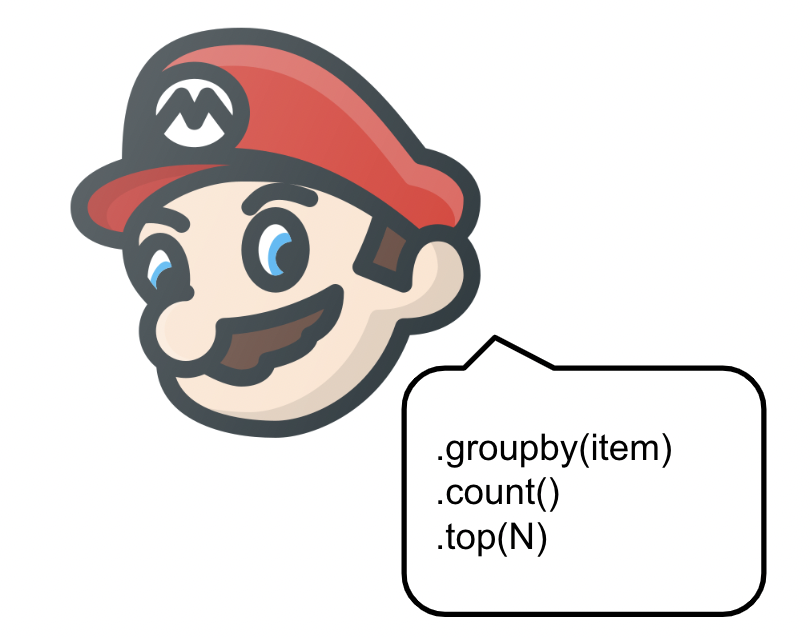

## Вариант 2  - использовать библиотеку `rectools`

Плюс там уже есть популярное по категориям 

### 1) Создаем объект `dataset`, куда отправляем interactions

Зачем так сложно? Почему нельзя просто работать с interactions (взаимодействиями)? 

В случае простого `.head(N)` может и возможно, но другие модели рекомендательных систем требуют хранения множества дополнительных вещей, например: 

- маппинга вида `исходный юзер / айтем id` - `внутренний юзер / айтем id`
- просмотренных айтемов для каждого юзера, которые желательно потом удалить из рекомендованных
- и тд

Поэтому приходим к тому, что проще инкапсулировать все эти свойства в один класс и передавать его объект в другие методы

In [61]:
from rectools.dataset import Dataset

dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

In [62]:
from rectools.models.popular import PopularModel

pop = PopularModel()
pop.fit(dataset);

# Проверяем, делает ли модель рекомендации для холодных 

![image.png](https://i.ibb.co/Bmx9Ytr/models-for-cold.png)
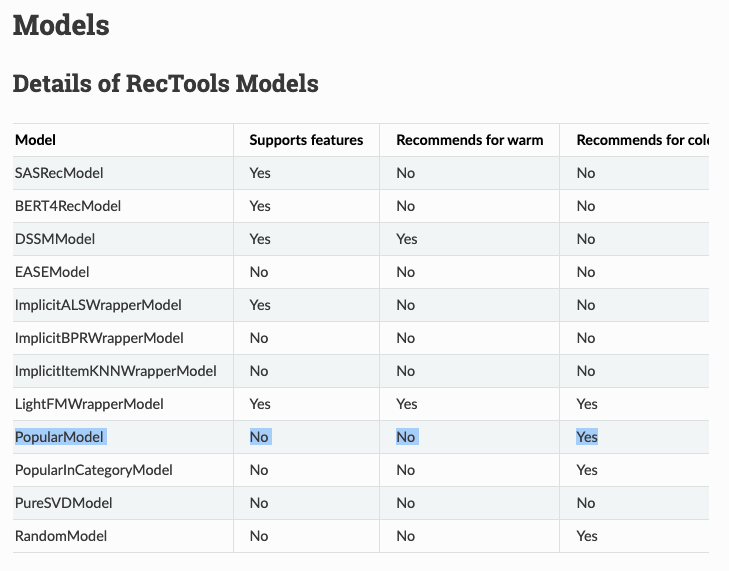

In [63]:
# несуществующий пользователь 
-9999999 in train.user_id.unique()

False

In [64]:
# Popular Model умеет рекомендовать для холодных пользователей
pop_recs = pop.recommend(
    [-9999999],
    dataset=dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций 
)

pop_recs.head(10)

,user_id,item_id,score,rank
0,-9999999,10440,"189,923.000000",1
1,-9999999,15297,"180,487.000000",2
2,-9999999,9728,"119,797.000000",3
3,-9999999,13865,"115,095.000000",4
4,-9999999,4151,"85,914.000000",5
5,-9999999,3734,"69,687.000000",6
6,-9999999,2657,"66,415.000000",7
7,-9999999,4880,"53,191.000000",8
8,-9999999,142,"42,877.000000",9
9,-9999999,6809,"39,498.000000",10


In [65]:
pop_recs = pop_recs.merge(items[['item_id', 'title']],
                           on='item_id',
                           how='left')
pop_recs

,user_id,item_id,score,rank,title
0,-9999999,10440,"189,923.000000",1,Хрустальный
1,-9999999,15297,"180,487.000000",2,Клиника счастья
2,-9999999,9728,"119,797.000000",3,Гнев человеческий
3,-9999999,13865,"115,095.000000",4,Девятаев
4,-9999999,4151,"85,914.000000",5,Секреты семейной жизни
5,-9999999,3734,"69,687.000000",6,Прабабушка легкого поведения
6,-9999999,2657,"66,415.000000",7,Подслушано
7,-9999999,4880,"53,191.000000",8,Афера
8,-9999999,142,"42,877.000000",9,Маша
9,-9999999,6809,"39,498.000000",10,Дуров


In [36]:
# рекомендации для всего теста
pop_recs = pop.recommend(
    test.user_id.unique(),
    dataset=dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций 
)

pop_recs = pop_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
pop_recs.head(10)

,user_id,item_id,score,rank,title
0,203219,10440,"189,923.000000",1,Хрустальный
1,203219,15297,"180,487.000000",2,Клиника счастья
2,203219,9728,"119,797.000000",3,Гнев человеческий
3,203219,13865,"115,095.000000",4,Девятаев
4,203219,4151,"85,914.000000",5,Секреты семейной жизни
5,203219,3734,"69,687.000000",6,Прабабушка легкого поведения
6,203219,2657,"66,415.000000",7,Подслушано
7,203219,4880,"53,191.000000",8,Афера
8,203219,142,"42,877.000000",9,Маша
9,203219,6809,"39,498.000000",10,Дуров


# А теперь посчитаем следущий вариант бейзлайна - популярное по категории

![image.png](https://i.ibb.co/LDPH2nhQ/popular-feat.png)

https://rectools.readthedocs.io/en/latest/api/rectools.models.popular_in_category.PopularInCategoryModel.html

PopularInCategoryModel генерирует рекомендации на основе популярности товаров внутри категорий. 
Основная идея заключается в том, что сначала определяется популярность категорий, 
затем внутри каждой категории отбираются самые популярные товары, 
а затем товары из разных категорий смешиваются в итоговый список рекомендаций.

•	category_feature – название признака категории в таблице характеристик товаров.
•	n_categories – число самых популярных категорий, которые учитываются в рекомендациях.
•	mixing_strategy – стратегия смешивания категорий: "rotate" (чередовать товары из разных категорий) или "group" (группировать по категориям).
•	ratio_strategy – стратегия распределения количества рекомендаций по категориям: "equal" (равномерно) или "proportional" (пропорционально популярности).
•	popularity – способ оценки популярности товара (например, n_users – число уникальных пользователей).
•	period / begin_from – временной диапазон для вычисления популярности.
•	add_cold – включать ли холодные товары (без взаимодействий).

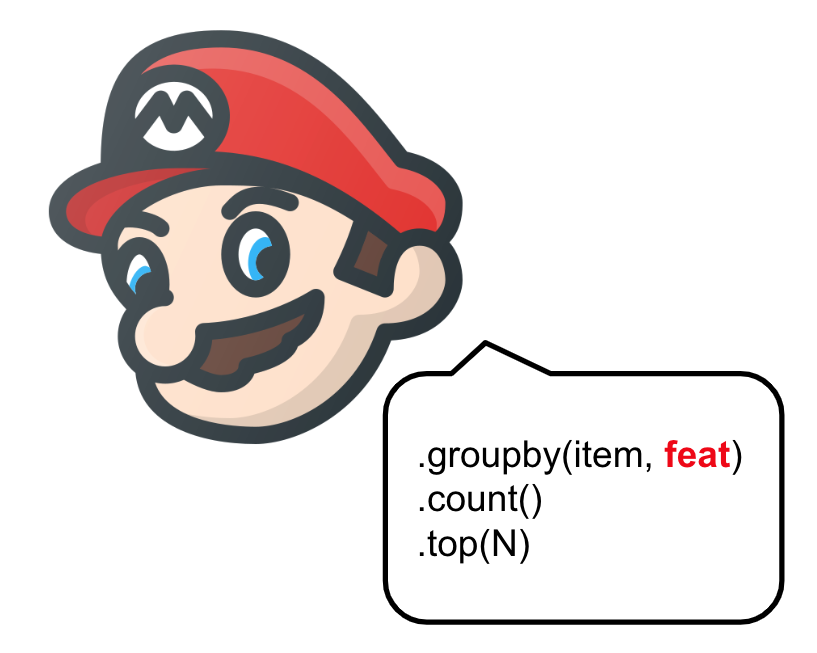

In [66]:
# популярность признаку genres
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head()

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии"
3,"[драмы, зарубежные, мелодрамы]","драмы, зарубежные, мелодрамы"
4,"[драмы, спорт, советские, мелодрамы]","драмы, спорт, советские, мелодрамы"


In [67]:
# делаем flatten представление фичи жанров
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [68]:
genre_feature = genre_feature[genre_feature['id'].isin(train['item_id'])]

In [69]:
dataset_feature = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre']
)

In [70]:
from rectools.models.popular_in_category import PopularInCategoryModel

pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5)
pop_cat.fit(dataset_feature);

In [71]:
pop_recs_cat = pop_cat.recommend(
    test.user_id.unique(),
    dataset=dataset_feature,
    k=10,
    filter_viewed=False  
)

In [72]:
pop_recs_cat = pop_recs_cat.merge(items[['item_id', 'title']],
                                   on='item_id',
                                   how='left')

pop_recs_cat

,user_id,item_id,score,rank,title
0,699317,15297,"180,487.000000",1,Клиника счастья
1,699317,9728,"119,797.000000",2,Гнев человеческий
2,699317,12192,"31,907.000000",3,Фемида видит
3,699317,7829,"18,080.000000",4,Поступь хаоса
4,699317,849,"13,610.000000",5,Дебошир
...,...,...,...,...,...
1112395,732646,13865,"115,095.000000",6,Девятаев
1112396,732646,7571,"26,242.000000",7,100% волк
1112397,732646,2657,"66,415.000000",8,Подслушано
1112398,732646,1844,"24,009.000000",9,Аферистка


# Еще один вариант популярного: посчитаем "покрытие" айтемов количеством уникальных пользователей covered by n% of unique users

Считаем что распределение айтемов выглядит как <a href="https://en.wikipedia.org/wiki/Zipf%27s_law"> Zip'f Law </a>. Напишем цикл для нахождения таких айтемов. Для этого нам неплохо иметь разряженную матрицу (csr). Получим ее у объекта dataset

- Выбираем самый популярный айтем по количеству уникальных просмотревших пользователей
- Исключаем этих пользователей 
- Ищем следующий самый популярный айтем
- Продолжаем пока не переберем всех пользователей 
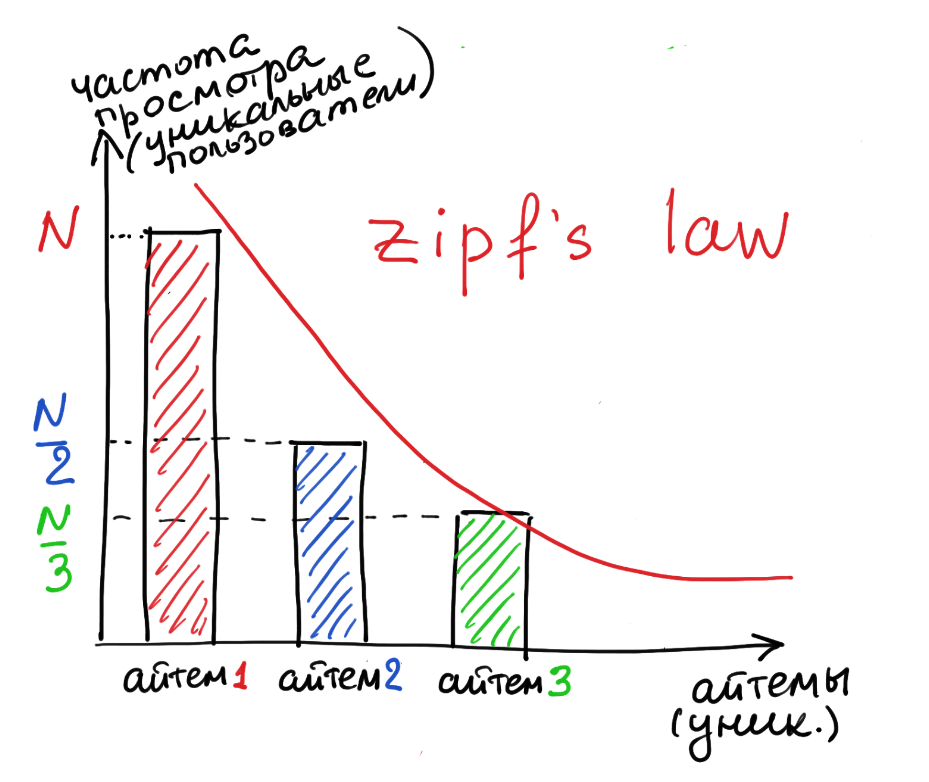

In [73]:
train['user_id'].nunique()

906071

In [74]:
# get csr matrix from interactions
matrix = dataset.get_user_item_matrix()

In [75]:
def get_top_items_covered_users(matrix, n_users=1000):

    assert matrix.format == 'csr'

    item_set = []
    # булев массив, по одному элементу на каждую строку матрицы (т.е. на каждого пользователя)
    # true если пользователь уже "покрыт" выбранными айтемами
    covered_users = np.zeros(matrix.shape[0], dtype=bool) 
    while covered_users.sum() < n_users: # пока не покрыто нужное число пользователей
        # 1) Определяем самый частотный айтем (моду) среди ещё непокрытых пользователей
        top_item = mode(matrix[~covered_users].indices, keepdims=True).mode[0]
        # 2) Добавляем этот айтем в итоговый набор
        item_set.append(top_item)
        # 3) Для всех пользователей проверяем, кто просматривал этот айтем
        covered_users += np.maximum.reduceat(matrix.indices==top_item, 
                                             matrix.indptr[:-1], dtype=bool)
    return item_set, covered_users

### Посмотрим наборы уникальных айтемов в зависимости от параметра n_users (сколько уникальных пользователей мы хотим учесть) в цикле

In [76]:
for n_users in range(100000, matrix.shape[0], 100000):
    item_set, covered_users = get_top_items_covered_users(matrix, n_users=n_users)
    print(f' with threshold to cover = {n_users} n_users:')
    print(f' items: {item_set}\n cover {covered_users.sum()} unique users \n')

 with threshold to cover = 100000 n_users:
 items: [24]
 cover 189923 unique users 
 with threshold to cover = 200000 n_users:
 items: [24, 20]
 cover 310832 unique users 
 with threshold to cover = 300000 n_users:
 items: [24, 20]
 cover 310832 unique users 
 with threshold to cover = 400000 n_users:
 items: [24, 20, 31, 15]
 cover 425076 unique users 
 with threshold to cover = 500000 n_users:
 items: [24, 20, 31, 15, 87, 165, 114, 79]
 cover 511735 unique users 
 with threshold to cover = 600000 n_users:
 items: [24, 20, 31, 15, 87, 165, 114, 79, 105, 133, 64, 9, 164, 341, 220, 122, 41, 10, 353, 322]
 cover 603158 unique users 
 with threshold to cover = 700000 n_users:
 items: [24, 20, 31, 15, 87, 165, 114, 79, 105, 133, 64, 9, 164, 341, 220, 122, 41, 10, 353, 322, 245, 148, 17, 203, 139, 497, 267, 423, 651, 56, 191, 2, 971, 35, 346, 14, 192, 49, 229, 564, 222, 434, 81, 137, 968, 76, 1555, 555, 189, 43, 96, 118, 281, 1433, 320, 157, 483, 364, 247, 1108, 162, 37, 233, 493]
 cover 70

In [77]:
item_set, covered_users = get_top_items_covered_users(matrix, n_users=600000)

In [78]:
# return to external item_id
pop_covered = dataset.item_id_map.convert_to_external(item_set)
pop_covered

array([10440, 15297,  9728, 13865,  2657,  4151,  6809,  3734,  4740,
        4880, 11237,  7571,  8636, 14741,  1844, 14431,  9996, 12173,
         142, 11863])

In [79]:
pop_recs_covered = pd.DataFrame({'user_id': test.user_id.unique()})
pop_recs_covered['item_id'] = [pop_covered[:10]] * pop_recs_covered.shape[0]
pop_recs_covered = pop_recs_covered.explode('item_id')
pop_recs_covered['rank'] = pop_recs_covered.groupby('user_id').cumcount() + 1

pop_recs_covered = pop_recs_covered.merge(
    items[['item_id', 'title']],
    on='item_id',
    how='left'
)

In [27]:
pop_recs_covered

,user_id,item_id,rank,title
0,203219,10440,1,Хрустальный
1,203219,15297,2,Клиника счастья
2,203219,9728,3,Гнев человеческий
3,203219,13865,4,Девятаев
4,203219,2657,5,Подслушано
...,...,...,...,...
1112395,857162,4151,6,Секреты семейной жизни
1112396,857162,6809,7,Дуров
1112397,857162,3734,8,Прабабушка легкого поведения
1112398,857162,4740,9,Сахаров. Две жизни


In [52]:
pop_recs_cat[pop_recs_cat['user_id'] == 203219]['title']

1080700      Клиника счастья
1080701    Гнев человеческий
1080702         Фемида видит
1080703        Поступь хаоса
1080704              Дебошир
1080705             Девятаев
1080706            100% волк
1080707           Подслушано
1080708            Аферистка
1080709                 Маша
Name: title, dtype: object

In [28]:
pop_recs_covered.shape

(1112400, 4)

# 1 + 2 + 3 Сравниваем все варианты

## Ключевая мысль: реранжирование

То есть мы видим в трех разных топах плюс-минус одинаковый набор айтемов, но на разных позициях относительно друг друга. Это как раз важное отличие рекомендаций друг от друга, так как ранжирование - основная задача рекомендательных систем. 

In [55]:
pd.concat([
    pop_recs[pop_recs['user_id'] == 203219].reset_index()[['title']],
    pop_recs_cat[pop_recs_cat['user_id'] == 203219].reset_index()[['title']],
    pop_recs_covered[pop_recs_covered['user_id'] == 203219].reset_index()[['title']]
], axis=1)

,title,title,title
0,Хрустальный,Клиника счастья,Хрустальный
1,Клиника счастья,Гнев человеческий,Клиника счастья
2,Гнев человеческий,Фемида видит,Гнев человеческий
3,Девятаев,Поступь хаоса,Девятаев
4,Секреты семейной жизни,Дебошир,Подслушано
5,Прабабушка легкого поведения,Девятаев,Секреты семейной жизни
6,Подслушано,100% волк,Дуров
7,Афера,Подслушано,Прабабушка легкого поведения
8,Маша,Аферистка,Сахаров. Две жизни
9,Дуров,Маша,Афера


# Метрика качества

In [80]:
from rectools.metrics import (calc_metrics, MeanInvUserFreq, 
                              AvgRecPopularity, MAP)

recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    "pop_covered": pop_recs_covered,
}

metrics= {
    'map@10': MAP(k=10), # качество ранжирования
    "novelty": MeanInvUserFreq(k=10), # глобальная новизна
    "arp": AvgRecPopularity(k=10),  # popularity bias
}

metrics_dict = {}
for model_name, recs in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs,
        interactions=test,
        prev_interactions=train,
        catalog=train[Columns.Item].unique(),
    )

In [82]:
pd.DataFrame(metrics_dict).T

,map@10,novelty,arp
pop,0.000000,3.435863,"96,288.400000"
pop_cat,0.062374,4.327433,"63,851.900000"
pop_covered,0.062070,3.470048,"95,383.800000"


In [62]:
pd.DataFrame(metrics_dict).reset_index(drop=False).to_csv('pop_metrics.csv', index=False)

# Выводы:
- популярное - это база, с которой стоит начинать
- популярное можно посчитать по-разному: простой топ / топ по признакам пользователей / топ по уникальным пользователям
- после того, как бейзлайн популярного будет побит - не отбрасываем его, а используем как 
    - техническую заглушку 
    - как кандидатов на ранжирование 
    - или как рекомендации для холодных пользователей
    

# TODO

что можно еще сделать 

- сравнить метрики качества на кросс-валидации 
- попробовать другие эвристики: топ новинок, топ Кинопоиска